In [ ]:
import sunpy.map
import astropy.units as u
from sunpy.net import Fido, attrs as a
# Choose any time and date for files from HMI instrument
unifresp = Fido.search(
    a.Time('2022-08-10 10:00:00', '2022-08-10 10:01:10'),
    a.Instrument("HMI"),
    a.Physobs.los_magnetic_field
)
 
print(unifresp)
# 'Fetch' to Download your file to a sunpy folder on your desktop
HMI_mag = Fido.fetch(unifresp)

Results from 1 Provider:

1 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2022-08-10 10:00:37.000 2022-08-10 10:00:38.000    SDO ...    FULLDISK -0.00098




In [176]:
import matplotlib.pyplot as plt
import numpy as np
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import glob
import sunpy.map
import sunpy.sun
from sunpy.coordinates import get_body_heliographic_stonyhurst

In [ ]:
HMI_01 = glob.glob(r"C:\Users\Admin\sunpy\data\hmi.m_45s.2022.08.10_10_01_30_TAI.magnetogram.fits")
PHI_01 =  glob.glob(r"C:\Users\Admin\OneDrive - Dublin City University\Day 1 astro\solo_L2_phi-fdt-blos_20220810T100009_V02.fits")

maps2 = sunpy.map.Map([HMI_01, PHI_01], sequence=True)

In [178]:
maps2 = [m.resample((1024, 1024)*u.pix) for m in maps2]

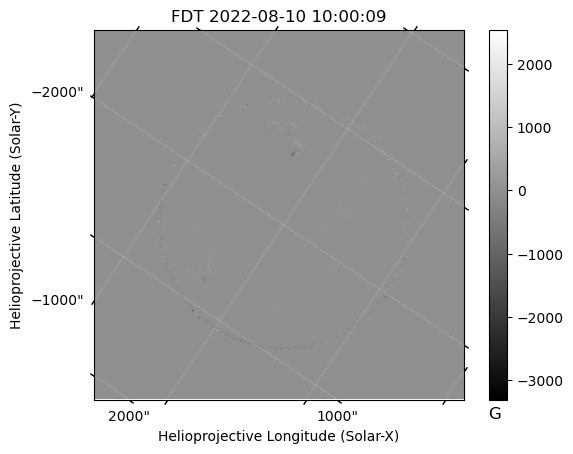

In [179]:
maps2[0].peek()

In [180]:
maps2[0].meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)

In [198]:
shape_out = (180, 360)  
header = sunpy.map.make_fitswcs_header(shape_out,
                                       SkyCoord(0, 0, unit=u.deg,
                                                frame="heliographic_stonyhurst",
                                                obstime=maps2[0].date),
                                       scale=[360 / shape_out[1],
                                              180 / shape_out[0]] * u.deg / u.pix,
                                       #wavelength=int(maps[0].meta['wavelength']) * u.AA,
                                       projection_code="CAR")
out_wcs = WCS(header)

In [182]:
array, footprint = reproject_and_coadd(maps2, out_wcs, shape_out,
                                       reproject_function=reproject_interp)

2025-12-29 13:58:36 - reproject.mosaicking.coadd - INFO: Output mosaic will have shape (180, 360)
2025-12-29 13:58:36 - reproject.mosaicking.coadd - INFO: Using on-the-fly mode for adding individual reprojected images to output array
2025-12-29 13:58:36 - reproject.mosaicking.coadd - INFO: Processing input data 1 of 2
2025-12-29 13:58:36 - sunpy - WARNING: SunpyUserWarning: The conversion of these 2D helioprojective coordinates to 3D is all NaNs because off-disk coordinates need an additional assumption to be mapped to calculate distance from the observer. Consider using the context manager `SphericalScreen()`.
2025-12-29 13:58:37 - reproject.mosaicking.coadd - INFO: Calling reproject_interp with shape_out=(180, 360)
2025-12-29 13:58:37 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-12-29 13:58:37 - reproject.mosaicking.coadd - INFO: Adding reprojected array to final array
2025-12-29 13:58:37 - reproject.mosaicking.coadd - INFO: Processing input data 2 of 2
20

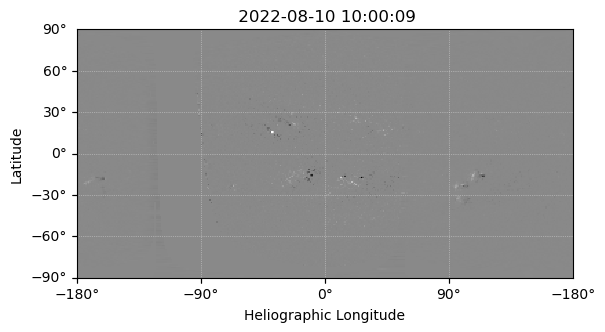

In [183]:
outmap2 = sunpy.map.Map((array, header))
outmap2.plot_settings = maps2[0].plot_settings

fig = plt.figure()
ax = fig.add_subplot(projection=outmap2)
outmap2.plot(axes=ax)

plt.show()

In [ ]:
# We need to Improve this output to make our ACtive Region more visible
coordinates2 = tuple(map(sunpy.map.all_coordinates_from_map, maps2))

In [185]:
weights2 = [coord.transform_to("heliocentric").z.value for coord in coordinates2]

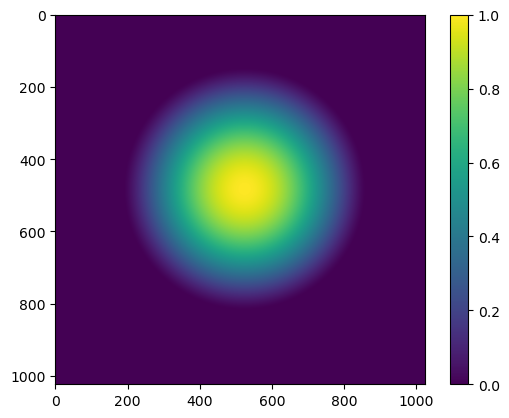

In [186]:
weights2 = [(w / np.nanmax(w)) ** 3 for w in weights2]
for w in weights2:
    w[np.isnan(w)] = 0

fig, ax = plt.subplots()
im = ax.imshow(weights2[0])
fig.colorbar(im)

plt.show()

In [187]:
array2, _ = reproject_and_coadd(maps2, out_wcs, shape_out,
                               input_weights=weights2,
                               reproject_function=reproject_interp,
                               match_background=True,
                               background_reference=0)

2025-12-29 13:58:48 - reproject.mosaicking.coadd - INFO: Output mosaic will have shape (180, 360)
2025-12-29 13:58:48 - reproject.mosaicking.coadd - INFO: Not using on-the-fly mode for adding individual reprojected images to output array
2025-12-29 13:58:48 - reproject.mosaicking.coadd - INFO: Processing input data 1 of 2
2025-12-29 13:58:48 - sunpy - WARNING: SunpyUserWarning: The conversion of these 2D helioprojective coordinates to 3D is all NaNs because off-disk coordinates need an additional assumption to be mapped to calculate distance from the observer. Consider using the context manager `SphericalScreen()`.
2025-12-29 13:58:48 - reproject.mosaicking.coadd - INFO: Calling reproject_interp with shape_out=(180, 360)
2025-12-29 13:58:48 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-12-29 13:58:48 - reproject.mosaicking.coadd - INFO: Calling reproject_interp with shape_out=(180, 360) for weights
2025-12-29 13:58:48 - reproject.common - INFO: Calling _repro

In [188]:
refmap2 = maps2[0]
array_reproj2, footprint2 = reproject_interp(outmap2, refmap2.wcs, shape_out=refmap2.data.shape)
outmap_reproj2 = sunpy.map.Map(array_reproj2, refmap2.meta)

2025-12-29 13:58:51 - reproject.common - INFO: Calling _reproject_full in non-dask mode


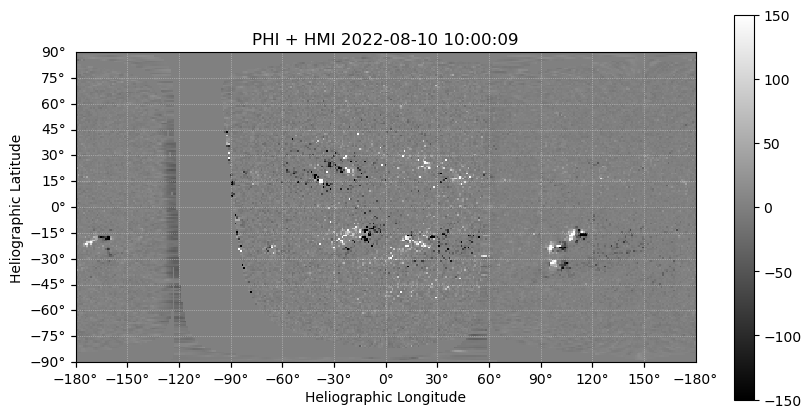

In [201]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.visualization import ImageNormalize
import sunpy.map

# Create the SunPy map
outmap2 = sunpy.map.Map((array, header))
outmap2.plot_settings = maps2[0].plot_settings
outmap2.nickname = 'PHI + HMI'

# Set up figure and axes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=outmap2)

# Set vmin and vmax based on your data
vmin = -150
vmax = 150

norm = ImageNormalize(outmap2.data, vmin=vmin, vmax=vmax)
im = outmap2.plot(axes=ax, norm=norm)

# Set coordinate labels and ticks
lon, lat = ax.coords
lon.set_axislabel('Heliographic Longitude', minpad=0.8)
lat.set_axislabel('Heliographic Latitude', minpad=0.9)
lon.set_ticks(spacing=30*u.deg)
lat.set_ticks(spacing=15*u.deg)

# Add colorbar
plt.colorbar(im, ax=ax)

Map01 = plt.show()

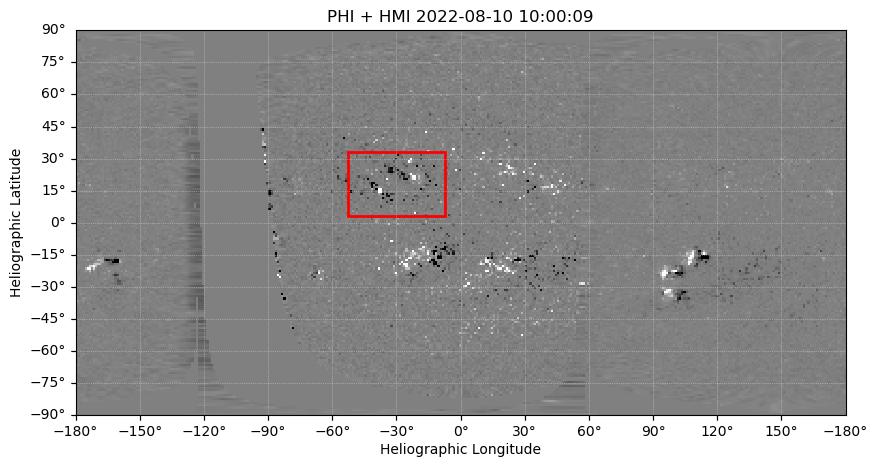

In [ ]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.visualization import ImageNormalize
import sunpy.map

# Create the SunPy map
outmap2 = sunpy.map.Map((array, header))
outmap2.plot_settings = maps2[0].plot_settings
outmap2.nickname = 'PHI + HMI'

# Set up figure and axes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=outmap2)

# Set vmin and vmax 
vmin = -150
vmax = 150

norm = ImageNormalize(outmap2.data, vmin=vmin, vmax=vmax)
im = outmap2.plot(axes=ax, norm=norm)

# Set coordinate labels and ticks
lon, lat = ax.coords
lon.set_axislabel('Heliographic Longitude', minpad=0.8)
lat.set_axislabel('Heliographic Latitude', minpad=0.9)
lon.set_ticks(spacing=30*u.deg)
lat.set_ticks(spacing=15*u.deg)

import matplotlib.patches as patches

lon_center = -30 * u.deg
lat_center = 18 * u.deg
box_width  = 45 * u.deg
box_height = 30 * u.deg

rect = patches.Rectangle(
    ((lon_center - box_width/2).value,
     (lat_center - box_height/2).value),
    box_width.value,
    box_height.value,
    edgecolor='red',
    facecolor='none',
    lw=2,
    transform=ax.get_transform(outmap2.coordinate_frame)
)
ax.add_patch(rect)

Map01 = plt.show()

In [ ]:
import numpy as np

# Size of your Box
lon_center = -30 * u.deg
lat_center = 18 * u.deg
box_width  = 45 * u.deg
box_height = 30 * u.deg

lon_min = lon_center - box_width/2
lon_max = lon_center + box_width/2
lat_min = lat_center - box_height/2
lat_max = lat_center + box_height/2

# Convert Carrington to pixel coordinates
x0, y0 = outmap2.wcs.world_to_pixel_values(lon_min.value, lat_min.value)
x1, y1 = outmap2.wcs.world_to_pixel_values(lon_max.value, lat_max.value)

x0, x1 = int(x0), int(x1)
y0, y1 = int(y0), int(y1)

# Extract the Magnetic Field region
subregion = outmap2.data[y0:y1, x0:x1]

# Compute stats
mean_abs_B   = np.abs(subregion).mean()
median_B = np.median(subregion)
min_B    = subregion.min()
max_B    = subregion.max()
std_B    = subregion.std()

print("Mean B-field:", mean_abs_B)
print("Min B-field:", min_B)
print("Max B-field:", max_B) # This is the most important one
print("Std dev:", std_B)


Mean B-field: 15.355738440266087
Min B-field: -485.8818152784119
Max B-field: 1047.7146066456614
Std dev: 51.196067962316235
